In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.externals import joblib
from sklearn import metrics, model_selection, svm
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from utils import walk, image_array

In [2]:
def get_array(dir_name):
    images = walk(dir_name)
    if images == []:
        raise FileNotFoundError('Diretório de imagens vazio ou não encontrado')
    npimages = np.asarray(image_array(images))
    npimages = np.reshape(npimages, (npimages.shape[0], npimages.shape[1] * npimages.shape[2]))
    print(npimages.shape)
    return npimages

In [3]:
npvazios = get_array('vazios')

(2338, 16384)


In [4]:
npnaovazios = get_array('naovazios')

(2896, 16384)


In [5]:
npvaziosdificeis = get_array('vaziosdificeis_depurado')

(1502, 16384)


In [6]:
npnaovaziosdificeis = get_array('naovaziosdificeis_depurado')

(1660, 16384)


In [7]:
y1 = np.linspace(0, 0, npvazios.shape[0])
y2 = np.linspace(1, 1, npnaovazios.shape[0])
y3 = np.linspace(0, 0, npvaziosdificeis.shape[0])
y4 = np.linspace(1, 1, npnaovaziosdificeis.shape[0])

In [8]:
X = np.concatenate((npvazios, npnaovazios, npvaziosdificeis, npnaovaziosdificeis), axis=0)
y = np.concatenate((y1, y2, y3,y4), axis=0)

### Primeiro um treinamento simples...

In [9]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                     test_size=.25,
                                     random_state=0)



In [10]:
svm_estimator = svm.SVC(kernel="rbf").fit(X_train, y_train)

In [11]:
y_pred = svm_estimator.predict(X_test)

In [12]:
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[961   2]
 [273 863]]
0.8689852310624107
             precision    recall  f1-score   support

        0.0       0.78      1.00      0.87       963
        1.0       1.00      0.76      0.86      1136

avg / total       0.90      0.87      0.87      2099



In [13]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print('Rotulo 0 Pred 0', tn)
print('Rotulo 0 Pred 1', fp)
print('Rotulo 1 Pred 0', fn)
print('Rotulo 1 Pred 1', tp)

Rotulo 0 Pred 0 961
Rotulo 0 Pred 1 2
Rotulo 1 Pred 0 273
Rotulo 1 Pred 1 863


In [19]:
joblib.dump(svm_estimator, 'SVCVazioDificeis.pkl')

['SVCVazioDificeis.pkl']

## Avaliação do modelo
De um total de 1.136 imagens rótulo 1-naovazio, 273 (22%) foram classificadas como 0-vazio. Inspecionando visualmente as 80 primeiras(abaixo), TODAS são de difícil distinção. Não dá para saber, visualmente, se o erro é de classificação ou de rótulo.

Já das 963 imagens rótulo 0-vazios, somente 2 não corresponderam na predição.

Considerando somente as bases "difíceis" de anteriormente, a precisão nos naovazios ainda é só de 35% (anteriormente 23%) mas a inspeção visual também não mostra nenhum contêiner claramente não vazio/contendo carga. Presume-se que se o ŕotulo estiver correto o contêiner tenha carga de FOAM, espumas, etc.

### Diante destas informações, considere-se o modelo bem satisfatório. 20-06-2017 16:28

#### TODO: se necessário, investigar conteúdo destes contêineres "falso vazio" e fazer algoritmo específico treinado somente para distinguir entre "falso vazio" e "vazio vazio"

In [15]:
yvd = svm_estimator.predict(npvaziosdificeis)
print('Precisão "vazios difíceis"', metrics.accuracy_score(y3, yvd))
ynvd = svm_estimator.predict(npnaovaziosdificeis)
print('Precisão "naovazios difíceis"', metrics.accuracy_score(y4, ynvd))

Precisão "vazios difíceis" 0.9986684420772304
Precisão "naovazios difíceis" 0.3530120481927711


275


<Figure size 432x288 with 0 Axes>

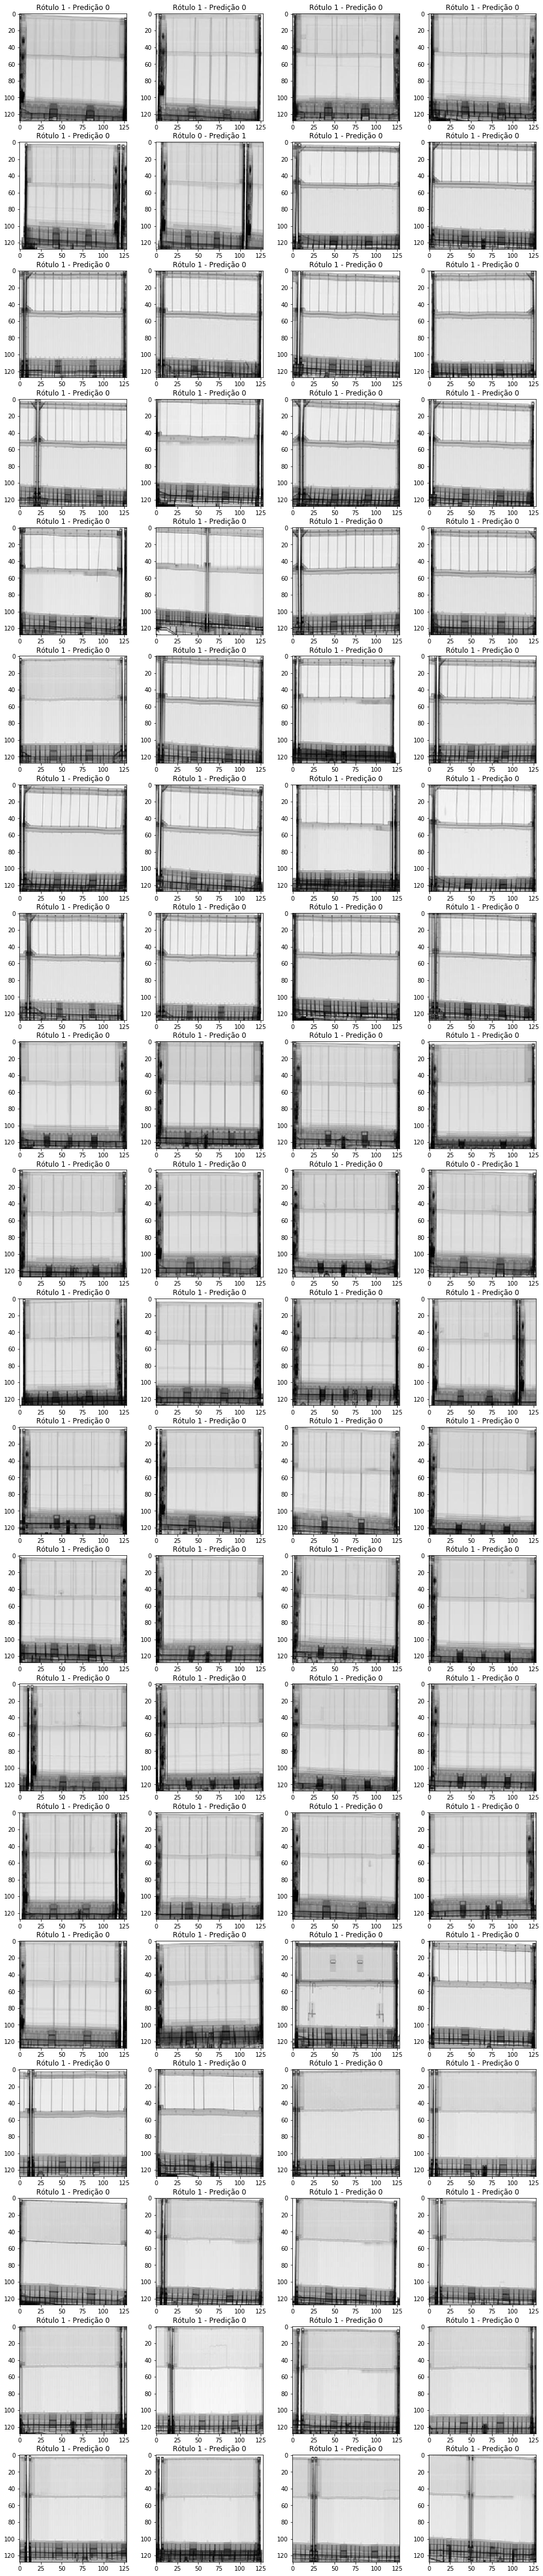

In [23]:
error_indexes = []
for index, (y_, y__) in enumerate(zip(y_test, y_pred)):
    if y_ != y__:
        error_indexes.append(index)
print(len(error_indexes))
# Mostrar no máximo 20 * 4 - 80 imagens
linhas = min(len(error_indexes) // 4 + 1, 20)
plt.gray()
fig=plt.figure(figsize=(16, 4*linhas))
for i, line in enumerate(error_indexes[:4*linhas]):
    img = np.asarray(X[line]).reshape(128, 128)
    ax = fig.add_subplot(linhas, 4, i + 1)
    ax.set_title('Rótulo %d - Predição %d' % (y_test[line], y_pred[line]))
    plt.imshow(img)
plt.show()

Total de registros  1660
Total de "erros" 1074


<Figure size 432x288 with 0 Axes>

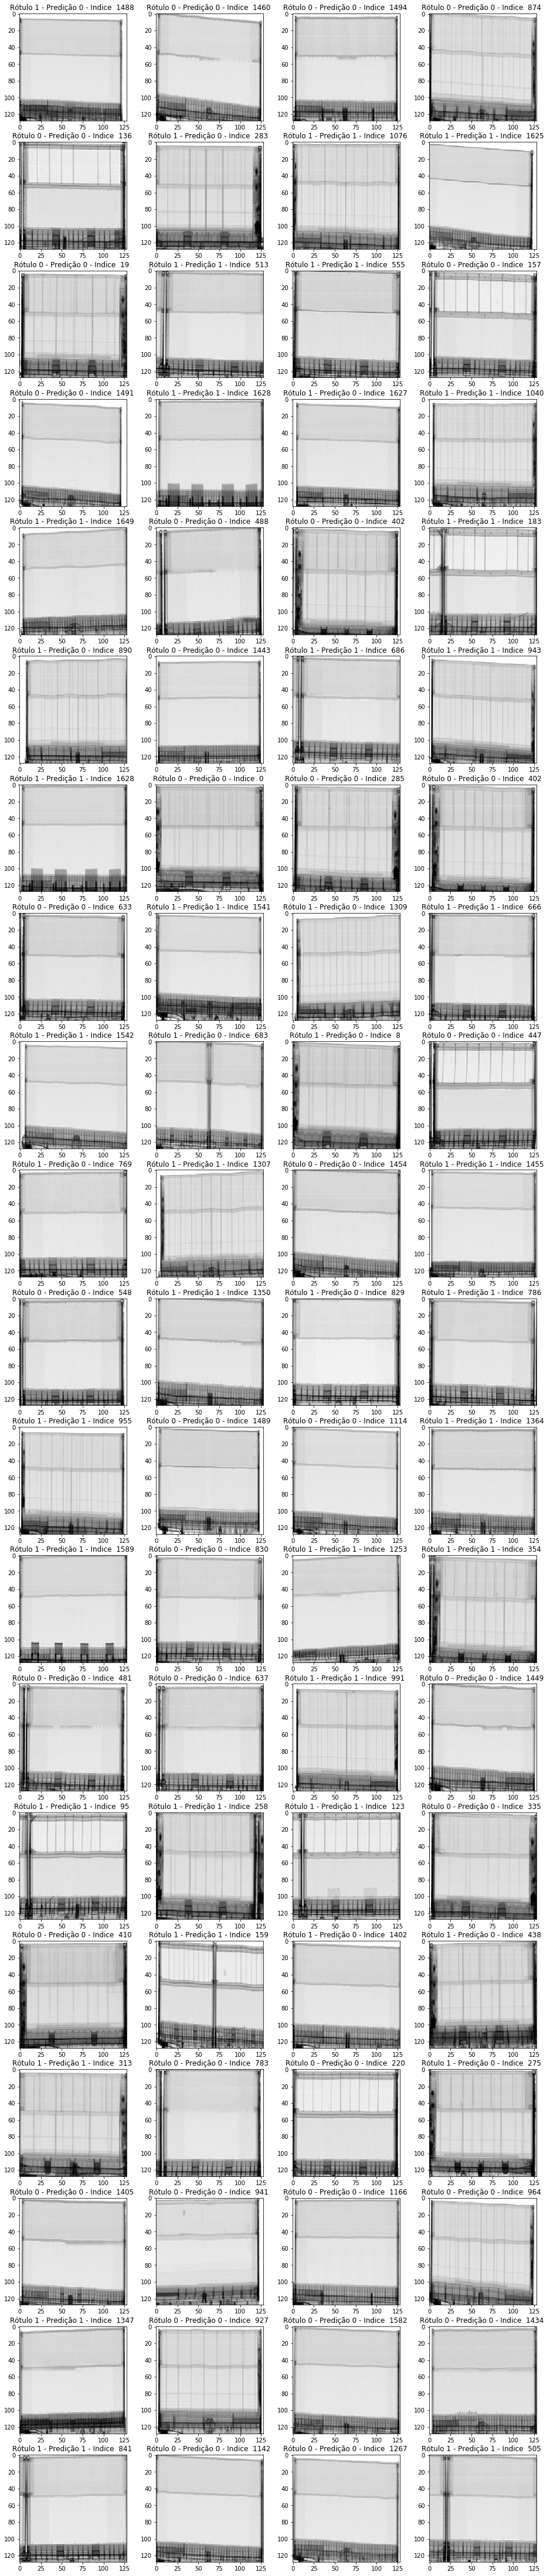

In [24]:
error_indexes = []
for index, (y_, y__) in enumerate(zip(y4, ynvd)):
    if y_ != y__:
        error_indexes.append(index)
print('Total de registros ', len(y4))
print('Total de "erros"', len(error_indexes))
# Mostrar no máximo 20 * 4 - 80 imagens
linhas = min(len(error_indexes) // 4 + 1, 20)
plt.gray()
fig=plt.figure(figsize=(16, 4*linhas))
indexes = np.random.randint(0, len(error_indexes), size=4*linhas)
for i, index in enumerate(indexes):
    line = error_indexes[index]
    img = np.asarray(X[line]).reshape(128, 128)
    ax = fig.add_subplot(linhas, 4, i + 1)
    ax.set_title('Rótulo %d - Predição %d - Indice % d ' % (y_test[line], y_pred[line], line))
    plt.imshow(img)
plt.show()

### Opção: Treinamento em GridSearch

In [ ]:
param_grid = [
  {'C': [1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

In [ ]:
joblib.dump(clf, 'SVCVazioDificeisGrid.pkl')

### Test class_weight parameter

In [ ]:
clfclass = svm.SVC(kernel="rbf", class_weight={0:.1, 1:.9}).fit(X_train, y_train)

In [ ]:
y_pred = clfclass.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

In [ ]:
joblib.dump(clf, 'SVCVazioDificeisClassWeight.pkl')